In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    !pip install gymnasium moviepy

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
VERBOSE = True

# Configurações
# NOME_AMBIENTE = "CliffWalking-v0"
MAXIMO_PASSOS = 9000
TAXA_APRENDIZADO = 0.2
DESCONTO = 0.95
EPSILON = 0.1
TEMPERATURA = 1.0

import envs #importa racetrack
envs = {
    "Cliffwalking": "CliffWalking-v0",
    "Frozen": "FrozenLake-v1",
    "Taxi": "Taxi-v3",
    "Racetrack": "RaceTrack-v0"  # ensure this env exists or adjust accordingly
}

/workspaces/rl-expected-sarsa-offpolicy/envs/wrappers.py:98: SyntaxWarning: invalid escape sequence '\g'
  '''Classe para converter espaços contínuos em espaços discretos.
/workspaces/rl-expected-sarsa-offpolicy/envs/wrappers.py:120: SyntaxWarning: invalid escape sequence '\g'
  '''Classe para converter espaços contínuos em espaços discretos.


In [4]:
def plot_multiple_results(resultados, log_scale=False):
    for grupo_nome, grupo_dados in resultados.items():

        plt.figure(figsize=(12, 6))
        plt.title(f"Resultados do grupo: {grupo_nome}")

        for politica_nome, recompensas in grupo_dados.items():
            plt.plot(recompensas, label=politica_nome)

        plt.xlabel("Passos")
        plt.ylabel("Recompensas")
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.show()

In [5]:
# Politicas

def politica_epsilon_gulosa(Q, estado, num_acoes, epsilon):
    probabilidades = [ (epsilon / num_acoes) ] * num_acoes
    acao_gulosa = np.argmax(Q[estado])
    probabilidades[acao_gulosa] += (1.0 - epsilon)
    return probabilidades

def politica_softmax(Q, estado, temperatura=1.0):
    valores_exp = np.exp(Q[estado] / temperatura)
    return valores_exp / np.sum(valores_exp)

def selecionar_acao(Q, estado, politica, **kwargs):
    probabilidades = politica(Q, estado, **kwargs)
    return np.random.choice(len(probabilidades), p=probabilidades)

In [6]:
def executar_expected_sarsa(ambiente, max_passos, taxa_aprendizado=0.1, desconto=0.95,
                          politica_treinamento=politica_epsilon_gulosa, politica_alvo=politica_epsilon_gulosa,
                          parametros_politica=None, exibir=False):
    num_acoes = ambiente.action_space.n
    Q = np.zeros((ambiente.observation_space.n, num_acoes))
    recompensas_por_episodio = []

    parametros_politica = parametros_politica or {}

    for i in tqdm(range(max_passos), desc="Treinando Expected-SARSA"):
        concluido = False
        recompensa_total = 0
        estado, _ = ambiente.reset()
        passos = 0  # Inicializa o contador de passos

        while not concluido and passos < 3000:  # Limita os passos dentro de cada episódio
            if exibir and (i >= (max_passos - 5) or (i+1) % 1000 == 0):
                ambiente.render()

            acao = selecionar_acao(Q, estado, politica_treinamento, **parametros_politica)
            proximo_estado, recompensa, terminou, truncado, _ = ambiente.step(acao)
            concluido = terminou or truncado

            # Cálculo do valor esperado usando a política alvo
            if terminou:
                valor_proximo_estado = 0
            else:
                prob_alvo = politica_alvo(Q, proximo_estado, **parametros_politica)
                valor_proximo_estado = np.sum(prob_alvo * Q[proximo_estado])

            # Atualização Q-value
            delta = (recompensa + desconto * valor_proximo_estado) - Q[estado, acao]
            Q[estado, acao] += taxa_aprendizado * delta

            recompensa_total += recompensa
            estado = proximo_estado
            passos += 1

        recompensas_por_episodio.append(recompensa_total)
    print("Treinamento concluído. Resultado médio: ", np.mean(recompensas_por_episodio))
    return recompensas_por_episodio, Q

In [7]:
def executar_experimentos(nome_ambiente, max_passos, taxa_aprendizado, desconto, epsilon, temperatura):
    ambiente = gym.make(nome_ambiente, max_episode_steps=500)

    politicas = {
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, num_acoes=len(Q[s]), epsilon=kw['epsilon']),
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, temperatura=kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s])
    }

    grupos = [
        ("1) TODOS x random", "aleatoria"),
        ("2) TODOS x epsilon-greedy", "epsilon-gulosa"),
        ("3) TODOS x softmax", "softmax")
    ]

    resultados = {}

    # Executar experimentos para cada grupo
    for nome_grupo, politica_alvo_nome in grupos:
        print(f"\n=== {nome_grupo} ===")
        grupo_resultados = {}

        for politica_treinamento_nome in politicas:
            print(f"Executando {politica_treinamento_nome} x {politica_alvo_nome}...")

            recompensas, _ = executar_expected_sarsa(
                ambiente, max_passos, taxa_aprendizado, desconto,
                politicas[politica_treinamento_nome],
                politicas[politica_alvo_nome],
                {"epsilon": epsilon, "temperatura": temperatura}
            )

            grupo_resultados[f"{politica_treinamento_nome}"] = recompensas

        resultados[nome_grupo] = grupo_resultados

    # Identificar melhores de cada grupo
    final_results = {}
    for grupo_nome, grupo_dados in resultados.items():
        medias = {k: np.mean(v[-100:]) for k, v in grupo_dados.items()}  # Média dos últimos 100 episódios
        melhor = max(medias, key=medias.get)
        final_results[f"{grupo_nome} ({melhor})"] = grupo_dados[melhor]

    resultados["FINAL) Melhores de cada grupo"] = final_results

    return resultados

In [8]:
results_per_env = {}

# Run experiments for each environment using the function from [`executar_experimentos`](Expected_SARSA_off_Policy.ipynb)
for env_label, env_name in envs.items():
    print(f"Running experiments for {env_label}")
    results = executar_experimentos(env_name, MAXIMO_PASSOS, TAXA_APRENDIZADO, DESCONTO, EPSILON, TEMPERATURA)
    results_per_env[env_label] = results
    print("==================================================================")

Running experiments for Cliffwalking

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA:   0%|          | 29/9000 [00:00<00:58, 152.96it/s]

Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:40<00:00, 222.78it/s] 


Treinamento concluído. Resultado médio:  -84.00477777777778
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:21<00:00, 416.07it/s]


Treinamento concluído. Resultado médio:  -37.153444444444446
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [04:46<00:00, 31.45it/s]


Treinamento concluído. Resultado médio:  -4959.449

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:07<00:00, 1267.63it/s]


Treinamento concluído. Resultado médio:  -21.738333333333333
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:16<00:00, 535.54it/s]


Treinamento concluído. Resultado médio:  -35.49377777777778
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [03:41<00:00, 40.58it/s]


Treinamento concluído. Resultado médio:  -4985.475222222222

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:08<00:00, 1094.24it/s]


Treinamento concluído. Resultado médio:  -45.525666666666666
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:15<00:00, 593.86it/s]


Treinamento concluído. Resultado médio:  -25.513555555555556
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [05:03<00:00, 29.63it/s]


Treinamento concluído. Resultado médio:  -5005.952444444444
Running experiments for Frozen

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:05<00:00, 1528.78it/s]


Treinamento concluído. Resultado médio:  0.06233333333333333
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:04<00:00, 1900.93it/s]


Treinamento concluído. Resultado médio:  0.015
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:04<00:00, 1953.78it/s]


Treinamento concluído. Resultado médio:  0.012888888888888889

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:07<00:00, 1143.84it/s]


Treinamento concluído. Resultado médio:  0.1758888888888889
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:03<00:00, 2275.70it/s]


Treinamento concluído. Resultado médio:  0.01877777777777778
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:03<00:00, 2590.21it/s]


Treinamento concluído. Resultado médio:  0.014444444444444444

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:07<00:00, 1244.18it/s]


Treinamento concluído. Resultado médio:  0.0
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:04<00:00, 1946.39it/s]


Treinamento concluído. Resultado médio:  0.013555555555555555
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:04<00:00, 1935.90it/s]


Treinamento concluído. Resultado médio:  0.012777777777777779
Running experiments for Taxi

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:27<00:00, 333.04it/s]


Treinamento concluído. Resultado médio:  -41.330888888888886
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:30<00:00, 291.34it/s]


Treinamento concluído. Resultado médio:  -43.095555555555556
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [05:00<00:00, 29.97it/s]


Treinamento concluído. Resultado médio:  -1825.5337777777777

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:12<00:00, 743.48it/s] 


Treinamento concluído. Resultado médio:  -5.370555555555556
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:16<00:00, 554.07it/s] 


Treinamento concluído. Resultado médio:  -7.730888888888889
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [05:16<00:00, 28.42it/s]


Treinamento concluído. Resultado médio:  -1823.3183333333334

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:11<00:00, 754.71it/s] 


Treinamento concluído. Resultado médio:  -5.639777777777778
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:13<00:00, 645.91it/s] 


Treinamento concluído. Resultado médio:  -5.314333333333333
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [05:21<00:00, 27.97it/s]


Treinamento concluído. Resultado médio:  -1828.7943333333333
Running experiments for Racetrack

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:46<00:00, 195.51it/s]


Treinamento concluído. Resultado médio:  -65.90377777777778
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:05<00:00, 136.57it/s]


Treinamento concluído. Resultado médio:  -91.90544444444444
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:10<00:00, 68.99it/s] 


Treinamento concluído. Resultado médio:  -187.4897777777778

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:48<00:00, 186.09it/s]


Treinamento concluído. Resultado médio:  -68.03911111111111
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:23<00:00, 108.08it/s]


Treinamento concluído. Resultado médio:  -106.83055555555555
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:24<00:00, 62.11it/s]


Treinamento concluído. Resultado médio:  -186.96077777777776

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [00:47<00:00, 191.39it/s]


Treinamento concluído. Resultado médio:  -66.175
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [01:11<00:00, 125.96it/s]


Treinamento concluído. Resultado médio:  -96.66855555555556
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 9000/9000 [02:18<00:00, 65.14it/s]

Treinamento concluído. Resultado médio:  -188.87577777777778


In [9]:
import matplotlib.pyplot as plt
from util.plot import smooth  # use the smooth function from util/plot.py

def plot_grouped_results(resultados, log_scale=False, smooth_window=None):
    num_groups = len(resultados)
    # Create one subplot per group in the same figure
    fig, axes = plt.subplots(1, num_groups, figsize=(6 * num_groups, 5)) if num_groups > 1 else plt.subplots(figsize=(6, 5))
    if num_groups == 1:
        axes = [axes]
        
    for ax, (grupo_nome, grupo_dados) in zip(axes, resultados.items()):
         ax.set_title(f"Resultados do grupo: {grupo_nome}")
         for politica_nome, recompensas in grupo_dados.items():
              # Apply smoothing if requested
              data = smooth(recompensas, smooth_window) if smooth_window is not None else recompensas
              ax.plot(data, label=politica_nome)
         ax.set_xlabel("Passos")
         ax.set_ylabel("Recompensas")
         if log_scale:
             ax.set_yscale("log")
         ax.legend()
    plt.tight_layout()
    plt.show()

Plotting results for Cliffwalking


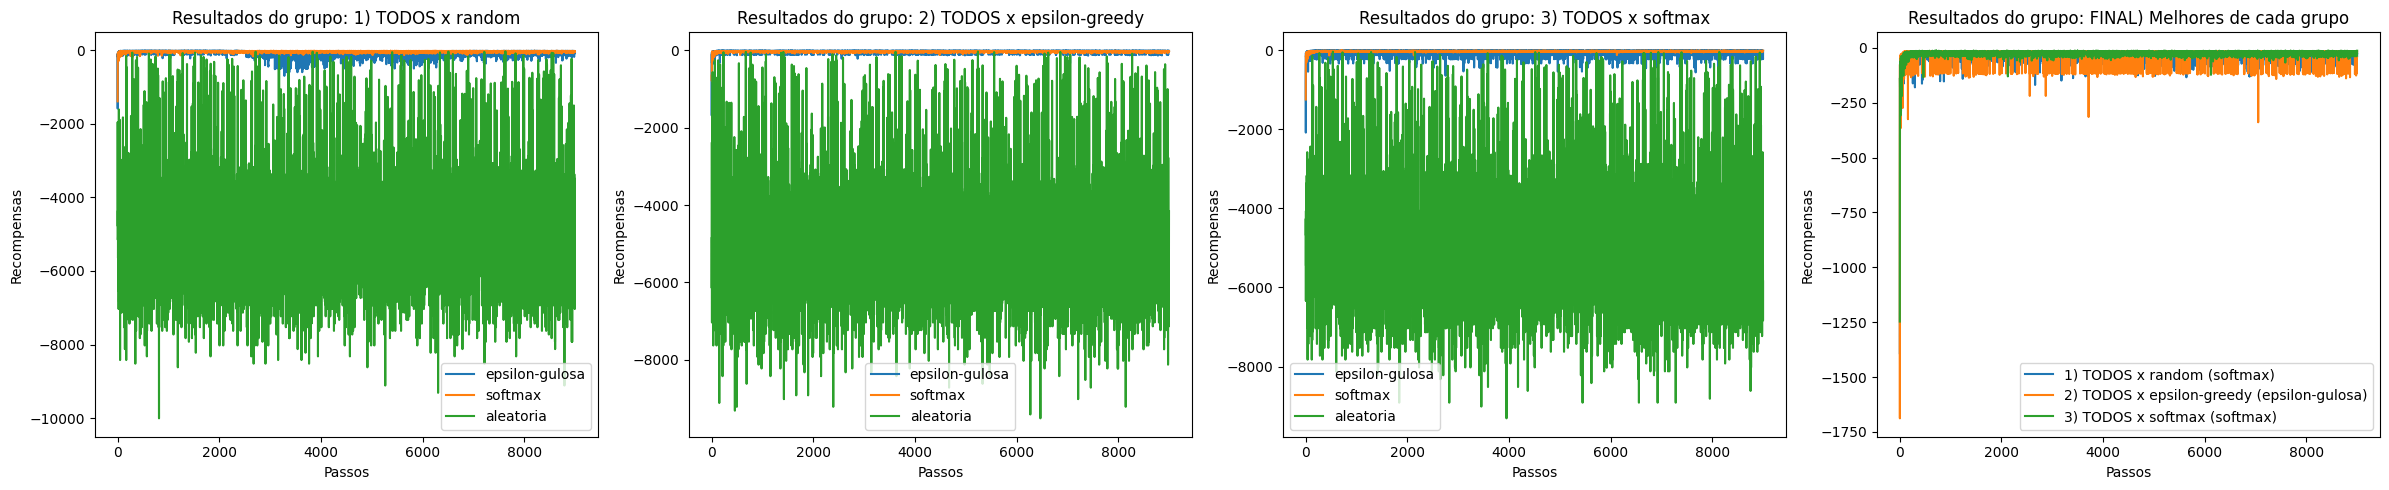

Plotting results for Frozen


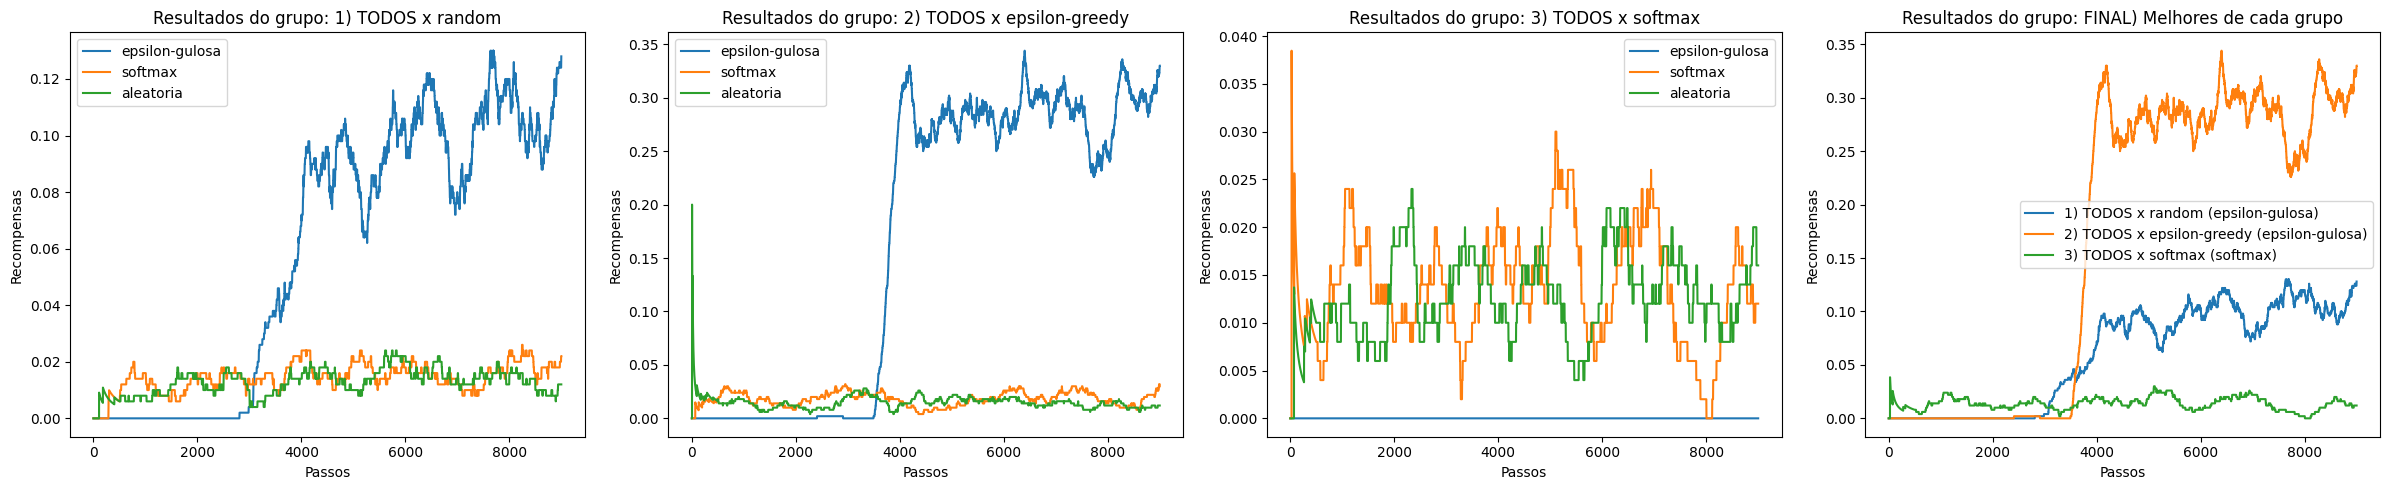

Plotting results for Taxi


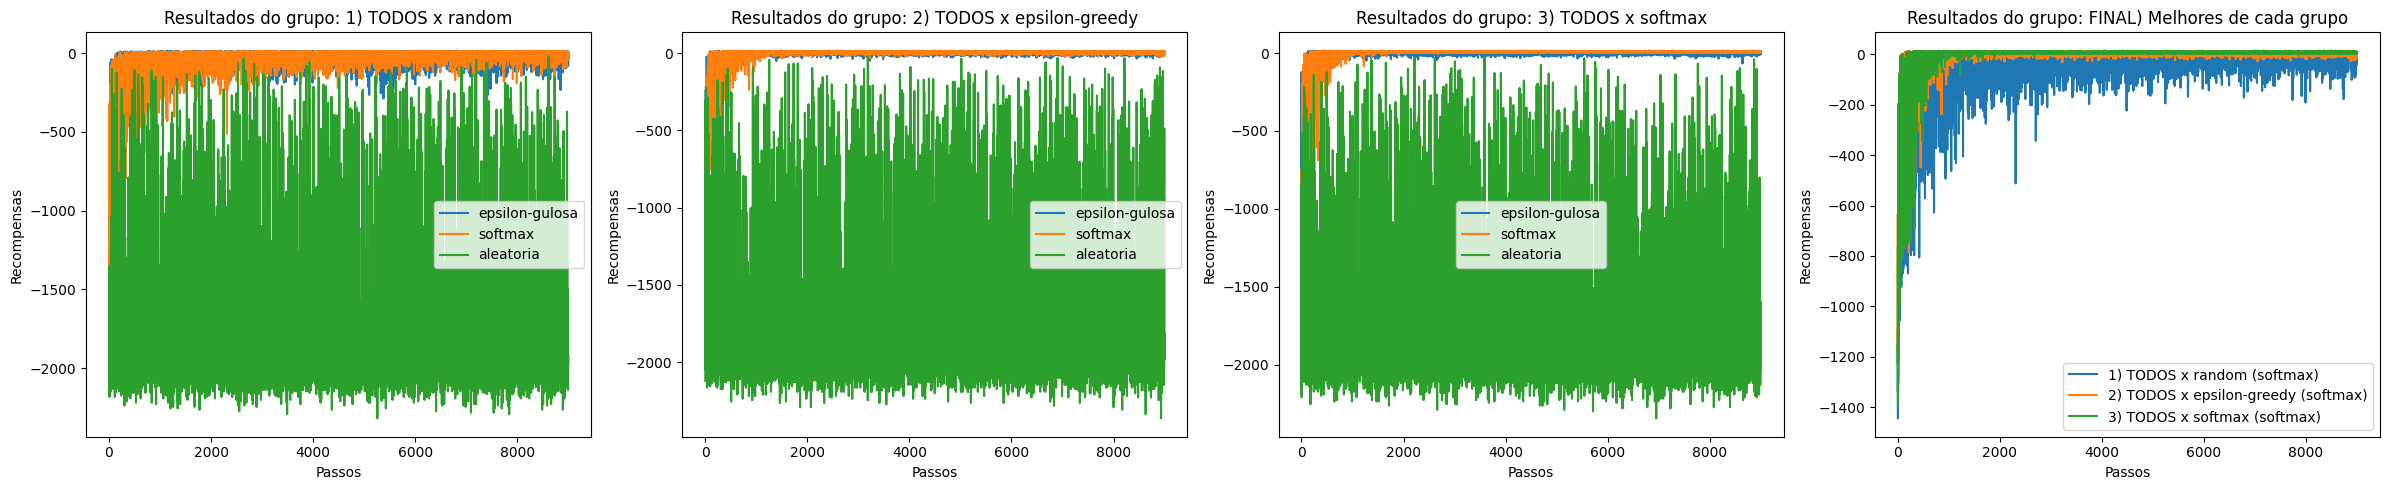

Plotting results for Racetrack


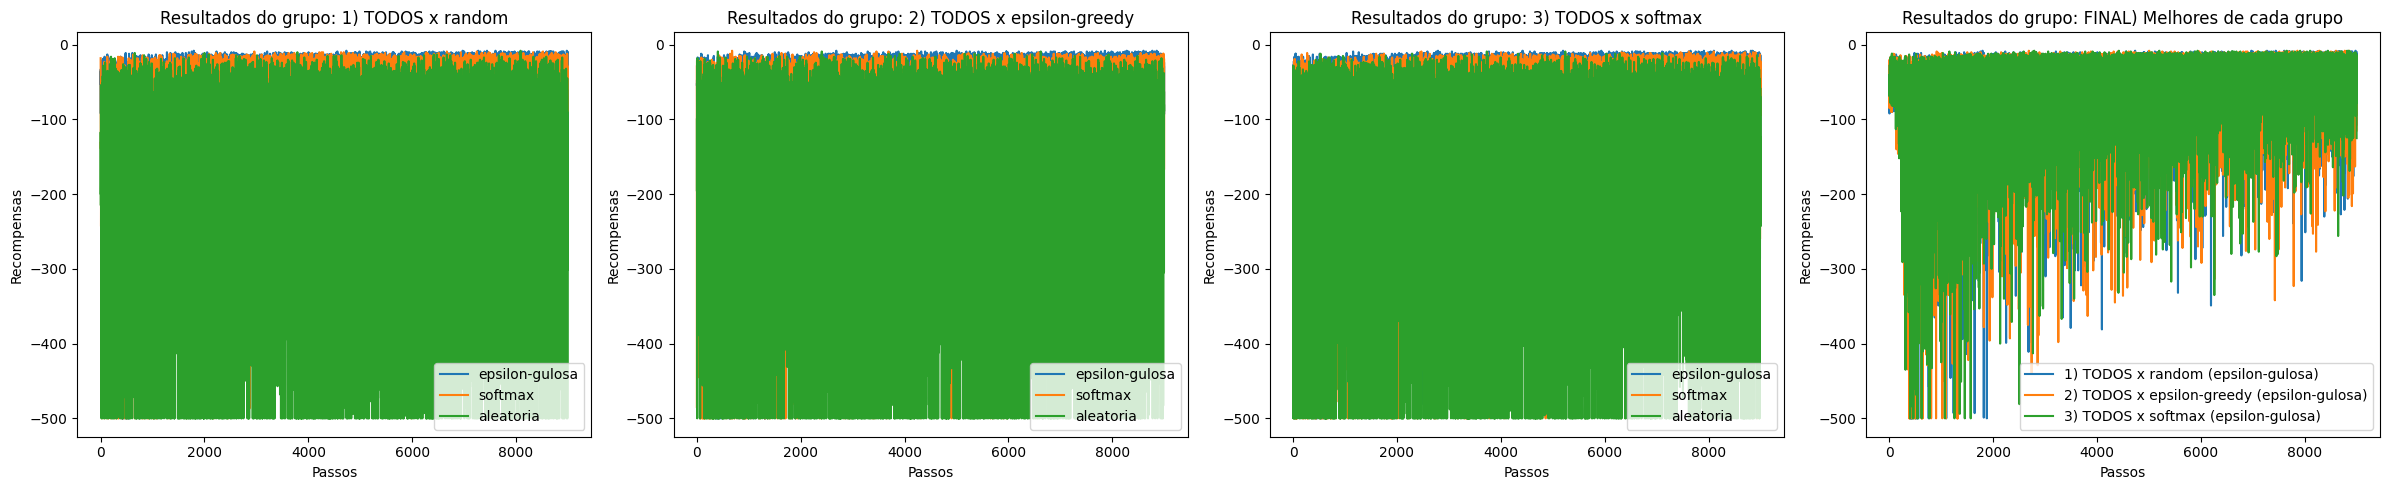

In [10]:
for env_label, env_results in results_per_env.items():
    print(f"Plotting results for {env_label}")
    if env_label == "Frozen":
        # Use a smoothing window of 500 episodes for Frozen Lake environment
        plot_grouped_results(env_results, log_scale=False, smooth_window=500)
    else:
        plot_grouped_results(env_results, log_scale=False) 